# Traveling Salesman Problem
## Exploring Algorithms Using Python
<br>
<p><b>Connor Owen</b><br>
Industrial and Systems Engineering<br>
Georgia Institute of Technology <br>
<a href="mailto:cowen33@gatech.edu">cowen33@gatech.edu</a></p>

The <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem"> traveling salesman problem</a> is a classic problem in combanitorial optimization that poses the following problem: 

<blockquote>A salesman is given a set of cities and the distances between them. Given that he can only visit each city once, and has to end in the origin city, what is the shortest possible route that he should take?</blockquote>

While the problem may seem trivial given a small number of cities to visit—you could simply calculate every possible tour—the problem becomes exponentially harder with each city added. In fact, this problem is considered <a href="https://en.wikipedia.org/wiki/NP-completeness">NP-complete</a>, meaning that the algorithms used to solve them increase exponentially in number of iterations for each additional city. However, because of the applications of the problem, there exists a wealth of information on optimal ways to solve the problem, both with exact algorithms that produce <i>the</i> optimal solution as well as approximate algorithms, that save time at the cost of exact optimality, while still producing a good solution. 

The TSP and its variations have a <a href="http://cdn.intechopen.com/pdfs/12736/intech-traveling_salesman_problem_an_overview_of_applications_formulations_and_solution_approaches.pdf">variety of applications</a>, ranging from the drilling of circuit boards<sup>[CITATION]</sup> to the routing of school buses<sup>[CITATION]</sup>, making it an important problem to explore. So in this notebook, we'll explore some of the more well-known algorithms that exactly solve and approximately solve the TSP. As part of the exercise, we'll take a look at the ease of implentation, the time to solve, and the solution itself. 

For the purpose of visualizing our results, we'll create a TSP based on Germany and its cities using Python's <a href="http://matplotlib.org/basemap/">Basemap</a> and Matplotlib. The geographic data of Germany is taken from the <a href="http://geonames.nga.mil/gns/html/namefiles.html#G">National Geospatial-Intelligence Agency</a> (NGA); the given shapefiles are then interpreted by the Python shapefile library. <br><br><br><br><br><br>


Before we get to the actual TSP, we read in the shapefiles from the NGA with the shapefile library. Our records are separated by the actual shape of the German borders, and then some data about the cities themselves, such as their coordinates, and their population. 

In [24]:
import shapefile

germanyRails = 'TSP/Germany/german_railways/railways' #CHANGE THESE TO GITHUB LINKS
cities = 'TSP/Germany/germany_places/places'
sf = shapefile.Reader(germanyRails + '.shp')
sf2 = shapefile.Reader(cities + '.shp')

shapes = sf.shapes()
fields = sf.fields
records = sf.records()
shapeRecs = sf.shapeRecords()

cityFields = sf2.fields
cityRecords = sf2.records()
cityShapes = sf2.shapes()

Here, out of our city data, we create a dictionary that we fill with cities in Germany that have a population greater than 100,000. The key is the city name and the value a tuple of coordinates, so that we can later plot it. 

In [25]:
# a dictionary of all the cities, with their points attached
cityDict = {}
for i in range(0,len(cityRecords)):
    if cityRecords[i][3] > 100000:
        cityDict[cityRecords[i][1]] = cityShapes[i].points

Now we combine our shapefile data with Basemap, a python library that provides us with a world map that we can define the boundaries of, and that we can plot data to. Our bounding box, which defines the portion of the map that we'll display, is taken from the shapefile, and alter passed as parameters into our map variable m. I found <a href="https://basemaptutorial.readthedocs.io/en/latest/#">this documentation</a> particularly useful when learning how to use Basemap.

In [26]:
from mpl_toolkits.basemap import Basemap

#load the map of Germany 
#loads the Germany map and draws it using Basemap and Matplotlib
bbox = sf.bbox
bbox[0] -= 0.08 #here we add a bit of padding to the bounding box
bbox[1] -= 0.08
bbox[2] += 0.08
bbox[3] += 0.08

#this is the map variable initiated by Basemap
m = Basemap(projection='merc',llcrnrlon=bbox[0], llcrnrlat=bbox[1], urcrnrlon=bbox[2],\
urcrnrlat=bbox[3], resolution='h', area_thresh=10000)
#the city data is then taken from another shapefile and made available to the map
m.readshapefile(cities, 'cities', drawbounds = False)

    

(61680,
 1,
 [5.8794689, 47.3161843, 0.0, 0.0],
 [15.0333333, 55.0403377, 0.0, 0.0])

Now that we have our map variable initiated, we can define a function that will display our map of Germany, and then plot on top all the cities with a population greater than 100,000.

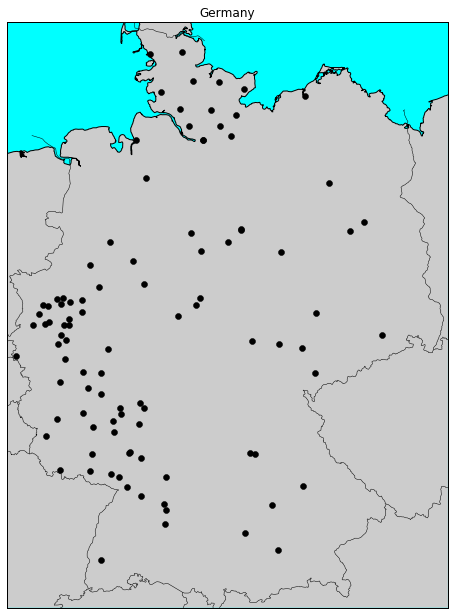

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline
def Germany():
    #initiate a figure with maplotlib
    fig = plt.gcf()
    #draw all the necessary parameters from the map
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents()
    m.drawmapboundary(fill_color='aqua')
    fig.set_size_inches(18.5, 10.5)
    plt.title("Germany")
    #plot the cities onto the map if they have a population > 100,000
    for info, city in zip(m.cities_info, m.cities):
        if info['population'] > 100000: 
            m.plot(city[0], city[1], 'ko')
    plt.show()

Germany()

Before we get into our algorithms to solve the TSP, we have to figure out a way to define the distances between each city. There are several ways that we could go about determining the distance between the cities, the most realistic being a road distance from city to city. However, for the purposes of this exercise, we will use great-circle distances (as the crow flies), calculated using the <a href="https://en.wikipedia.org/wiki/Haversine_formula">Haversine formula</a>. 

In [29]:
import numpy as np
import math

#Given two cities, this function calculates distance
def distance(city1, city2):

    lat1 = cityDict[city1][0][1]
    lat2 = cityDict[city2][0][1]
    lon1 = cityDict[city1][0][0]
    lon2 = cityDict[city2][0][0]

    #first convert the lat and lon (in decimal form) to radians
    lat1, lat2, lon1, lon2 = map(math.radians, [lon1, lon2, lat1, lat2])

    #set the radius of the earth to 6367km
    R = 6367

    #now use the Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d 


We now use the distance function defined above to populate a distance dictionary, where each city is mapped to every other city with the distance between them, using a nested dictionary structure. Later, we can access the distance by using the two cities names as the dictionary and nested-dictionary keys.

In [30]:
#creates a dictionary to save the distance between every city
distDict = {}
for city in cityDict.keys(): 
    distDict[city] = {x:distance(city,x) for x in cityDict.keys() if x != city}

Before we begin our algorithms, we define our test sets by randomy sampling from our cities. The algorithms will except these various lists of cities in order to decide the optimal tour. 

In [41]:
#create a list of cities from the city dictionary
cities = list(cityDict.keys())

#We assume that the first city of the list is the starting city for each algorithm
#create three testing lists to be used in for analyzing the optimization algorithms
miniTest = sample(cities,5)
smallTest = sample(cities,10)
mediumTest = sample(cities, 20)
largeTest = sample(cities,40)
maxTest = sample(cities, 97)


Now we have all the pieces we need to start constructing our algorithms! 

First we will start with arguably the most basic exact algorithm—an exhaustive search. Given a list of cities, we use the itertools library to create a list of permutations of each city. This list represents every possible tour you could take to visit every city just once. We then go through the list, and see which tour has the shortest distance

This algorithm is extremely inefficient, creating (N-1)! calculations, with N being the number of cities. In fact, to not crash the computer, we limit the code to only work on lists of 10 or less cities. Just considering 11 cities would require iterating 10! tours—3,628,800 possibly solutions. However, it does guarantee us the optimal solution, so we can consider it for smaller test sets. 

In [31]:
import time
from itertools import permutations

def ExhaustiveSearch(cities):
    #to manually limit the num of cities to not break computer
    if len(cities) <= 10:
        #initiate clock to time algorithm
        t0 = time.clock()

        esList = list(cities[:])
        totalDistance = 0 
        #pop out the first city to have a starting point
        city1 = esList.pop(0)
        optimalList = []
        perms = list(permutations(esList)) #list of tuples of permutations of cities given a starting city

        cityTuple = perms[0]
        tourDistance = distDict[city1][cityTuple[0]] #get distance from starting city to first one
        pairings = [(city, cityTuple[i]) for i, city in enumerate(cityTuple[1:])] #to move from one city to the next
        pairings.append((cityTuple[-1], city1))
        tourDistance += sum([distDict[city[0]][city[1]] for city in pairings]) #compute distance for tour
        bestDistance = tourDistance
        bestTour = cityTuple

        for cityTuple in perms[1:]:
            tourDistance = distDict[city1][cityTuple[0]] #get distance from starting city to first one
            pairings = [(city, cityTuple[i]) for i, city in enumerate(cityTuple[1:])] #to move from one city to the next
            pairings.append((cityTuple[-1],city1))
            tourDistance += sum([distDict[city[0]][city[1]] for city in pairings]) #compute distance for tour
            if tourDistance < bestDistance: #replaces best distance so far in iterative fashion
                bestDistance = tourDistance 
                bestTour = cityTuple

        #calculate running time of algorithm 
        tf = time.clock()
        dt = tf - t0
    
        return bestTour, bestDistance, dt, 

Optimal Tour: ('Trier-Saarburg', 'Mainz-Bingen', 'Mannheim', 'Jena', 'Braunschweig', 'Freie und Hansestadt Hamburg', 'Rendsburg-Eckernförde', 'Remscheid', 'Solingen')
Total Distance: 1656km


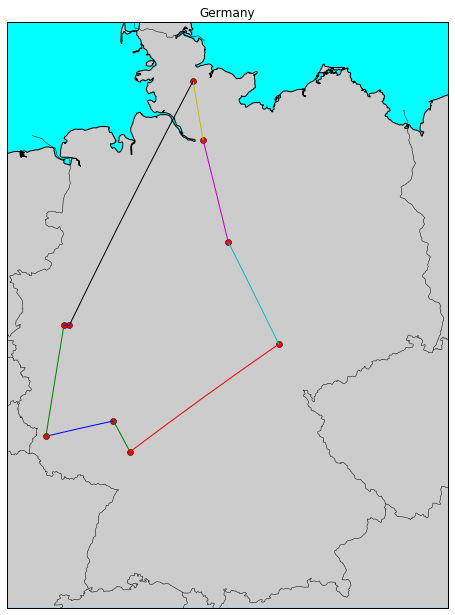

In [32]:
i = ExhaustiveSearch(smallTest)
print('Optimal Tour: {}'.format(i[0]))
print('Total Distance: {0:.0f}km'.format(i[1]))

fig = plt.gcf()
m.drawcoastlines()
m.drawcountries()
m.fillcontinents()
m.drawmapboundary(fill_color='aqua')
fig.set_size_inches(18.5, 10.5)
plt.title("Germany")
pairings = [(city, i[0][x]) for x, city in enumerate(i[0][1:])]
pairings.append((i[0][0], i[0][-1]))

#set up coordinates to map onto plot
x = []
y = []
for pair in pairings:
    lon1 = cityDict[pair[0]][0][0]
    lat1 = cityDict[pair[0]][0][1]
    lon2 = cityDict[pair[1]][0][0]
    lat2 = cityDict[pair[1]][0][1]
    x,y = m(lon1, lat1)
    m.plot(x, y, 'ro', markersize=6)
    m.drawgreatcircle(lon1, lat1, lon2, lat2)

plt.show()


The next algorithm we'll consider is arguably the simplest of the approximate algorithms. It is the <a href="https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm">Nearest Neighbor Algorithm</a>, which falls under the Greedy Algorithm family. 

It provides us a simple heuristic to operate on: for each city, go to the nearest unvisited city, and back to the origin at the last iteration. The algorithm has no guarantees of optimality, and can even yield the worst case scenario in certain situations. However, in terms of implentation, it is one of the simplest approximate algorithms, and will often work better than a random tour. 

In [33]:
##Nearest Neighbor Algorithm
def NearestNeighbor(cities):
    
    #initiate clock to start algorithm
    t0 = time.clock()
    
    optimalList = []
    nnList = list(cities[:]) #creates a copy to not destroy list for other runs
    city1 = nnList.pop(0)
    optimalList = [city1]
    totalDistance = 0

    while len(nnList) != 0:
        distanceList = []
        for city in nnList:
            distanceList.append(distance(city1, city))
        minDistance = min(distanceList)
        totalDistance += minDistance
        nearestCity = nnList.pop(distanceList.index(minDistance))
        optimalList.append(nearestCity)
    tf = time.clock()
    dt = tf - t0
    
    return optimalList, totalDistance, dt


Optimal Tour: ['Duisburg', 'Moers', 'Neuss', 'Essen', 'Leverkusen', 'Köln', 'Bonn', 'Aachen', 'Ahrweiler', 'Trier-Saarburg', 'Alzey-Worms', 'Darmstadt', 'Mannheim', 'Pinneberg', 'Braunschweig', 'Schleswig-Flensburg', 'Kreis Plön', 'Jena', 'Ingolstadt', 'München']

Total Distance: 5077.827957118313



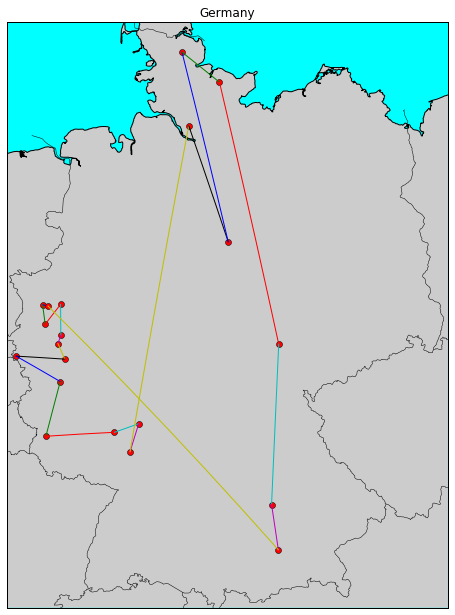

In [35]:
i = NearestNeighbor(mediumTest)

fig = plt.gcf()
m.drawcoastlines()
m.drawcountries()
m.fillcontinents()
m.drawmapboundary(fill_color='aqua')
fig.set_size_inches(18.5, 10.5)
plt.title("Germany")

pairings = [(city, i[0][x]) for x, city in enumerate(i[0][1:])]
pairings.append((i[0][0], i[0][-1]))

x = []
y = []
for pair in pairings:
    lon1 = cityDict[pair[0]][0][0]
    lat1 = cityDict[pair[0]][0][1]
    lon2 = cityDict[pair[1]][0][0]
    lat2 = cityDict[pair[1]][0][1]
    x,y = m(lon1, lat1)
    m.plot(x, y, 'ro', markersize=6)
    m.drawgreatcircle(lon1, lat1, lon2, lat2)
    
print("Optimal Tour: {}\n".format(i[0]))
print("Total Distance: {}\n".format(i[1]))
plt.show()


In [36]:
from random import shuffle
from random import sample 
from random import random
from math import exp
from math import log10

def SimulatedAnnealing(cities):
    #initiate clock to time algorithm
    t0 = time.clock()
    
    simList = list(cities[:])
    shuffle(simList) #randomize order of cities 

    ##PARAMETERS
    kmax = 10000 #number of iterations to consider--converges asymptotically
    #solSet = []
    pairings = [(city, simList[i]) for i, city in enumerate(simList[1:])] #to move from one city to the next
    pairings.append((simList[-1], simList[0]))
    tourDistance = sum([distance(city[0],city[1]) for city in pairings])
    bestDistance = tourDistance
    
    solutions = []

    for k in range(0,kmax): 
        T = temp(k) #cooling schedule  
        randomNeighbor = neighbor(list(simList))
        pairings2 = [(city, randomNeighbor[i]) for i, city in enumerate(randomNeighbor[1:])]
        pairings2.append((randomNeighbor[-1], randomNeighbor[0]))
        candidateDistance = sum([distance(city[0],city[1]) for city in pairings2])
        if  candidateDistance < bestDistance:
            simList = randomNeighbor
            bestDistance=candidateDistance #downhill move
            #solSet.append((1, candidateDistance, bestDistance))
        elif exp(-(candidateDistance-bestDistance)/T)  > random():  #If PR() >= randomUniform(0,1), then switch
            #solSet.append((exp(-(candidateDistance-bestDistance)/T), candidateDistance, bestDistance))
            simList = randomNeighbor
            bestDistance = candidateDistance #moving uphill with limited probability
        if k%333 == 0: 
            solutions.append(simList)
            
            
    tf = time.clock()
    dt = tf - t0
     
    return(simList, bestDistance, dt, solutions)

In [37]:
def temp(k):
    T0 = 1000 #initial temperature parameter; must be high enough to accept almost any state transition to worse solution
    #a = 0.99
    #T = T0*a**k ##exponential multiplicative cooling
    #T = T0/log10((k+2)**0.5)
    T = 1/log10(k+2) #inverse log time cooling
    return(T)
    
##Helper function to shuffle two cities in the tour to get 'neighbor'
def neighbor(aList):
    randints = sample(range(0, len(aList)-1),2) #sample 2 integers of the positions of the list
    randints.sort()
    start = randints[0]
    end = randints[1]
    cList = [aList[x] for x in range(start,end+1)] #read the cities into a temporary list
    for i,j in zip(range(end, start-1, -1), range(0, len(cList))):     #reverse order of cities
        aList[i] = cList[j]
    return aList

def neighbor2(aList):
    randints = sample(range(0, len(aList)-1),2) #sample 2 integers of the positions of the list
    randints.sort()
    start = randints[0]
    end = min([start+3,len(aList)-1])
    cList = [aList[x] for x in range(start,end+1)] #read the cities into a temporary list
    for i,j in zip(range(end, start-1, -1), range(0, len(cList))):     #reverse order of cities
        aList[i] = cList[j]
    return aList

Optimal Tour: ['Leverkusen', 'Köln', 'Bonn', 'Ahrweiler', 'Aachen', 'Trier-Saarburg', 'Alzey-Worms', 'Mannheim', 'Darmstadt', 'München', 'Ingolstadt', 'Jena', 'Braunschweig', 'Kreis Plön', 'Schleswig-Flensburg', 'Pinneberg', 'Essen', 'Duisburg', 'Moers', 'Neuss']

Optimal Distance: 2361.1310109003407


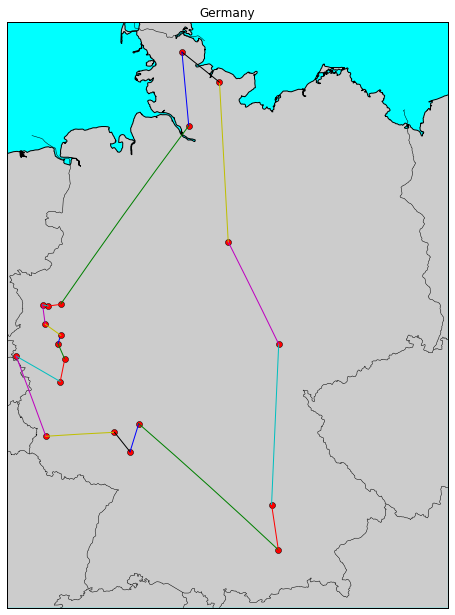

In [39]:
i = SimulatedAnnealing(mediumTest)

fig = plt.gcf()
m.drawcoastlines()
m.drawcountries()
m.fillcontinents()
m.drawmapboundary(fill_color='aqua')
fig.set_size_inches(18.5, 10.5)
plt.title("Germany")
pairings = [(city, i[0][x]) for x, city in enumerate(i[0][1:])]
pairings.append((i[0][0], i[0][-1]))

x = []
y = []
for pair in pairings:
    lon1 = cityDict[pair[0]][0][0]
    lat1 = cityDict[pair[0]][0][1]
    lon2 = cityDict[pair[1]][0][0]
    lat2 = cityDict[pair[1]][0][1]
    x,y = m(lon1, lat1)
    m.plot(x, y, 'ro', markersize=6)
    m.drawgreatcircle(lon1, lat1, lon2, lat2)
    
print("Optimal Tour: {}\n".format(i[0]))
print("Optimal Distance: {}".format(i[1]))
plt.show()



We also will define a simple random tour to compare its performance to the other algorithms. It's as if the salesman randomly chose how to go from city to city with no consideration to cost. 

In [40]:
def randomTour(cities):
    perms = list(permutations(cities)) #list of tuples of permutations of cities given a starting city
    cityTuple = perms[rint(0,len(perms)-1)]
    pairings = [(city, cityTuple[i]) for i, city in enumerate(cityTuple[1:])] #to move from one city to the next
    pairings.append((cityTuple[-1], cityTuple[0]))
    tourDistance = sum([distDict[city[0]][city[1]] for city in pairings]) #compute distance for tour
        
    return(0, tourDistance)

Now that we have defined our algorithms, we can take a look at their performance. In general we can measure their usefuleness as a combination of their accuracy as well as their efficiency. An accurate algorithm in this case would tell us the exact optimal solution; it would always be right. However, due to the nature of the NP hard problems, these cost us a considerable amount of time. Therefore, we also heavily consider time, given that the solution provided is reasonably close to the optimal solution. 

The balance of the accuracy and time needed will depend on the context of the problem. For instance, in a dynamic situation where you constantly solve this type of problem with a large problem set, then an exact algorithm might be too costly in terms of time. On the other hand, in a case where you need to solve the problem only once, then an exact algorithm might fit in the time frame, and the time cost would not outweigh the benefit of having the optimal solution. 

We will start with a comparison of the "optimal" distance provided by the different algorithms:

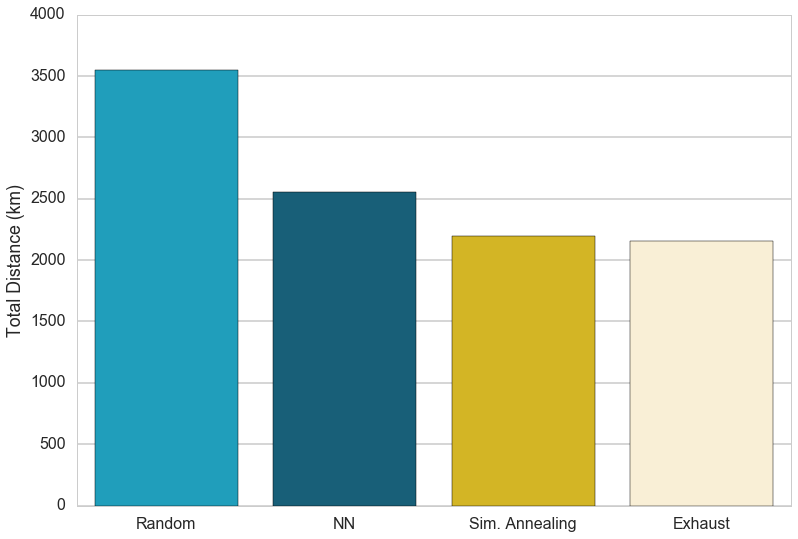

In [44]:
##plot the comparisons of the different algorithms 
from random import randint as rint
import seaborn as sns
import pandas as pd
results = (,(ExhaustiveSearch(smallTest), "Exhaust"), 
           (SimulatedAnnealing(smallTest), "Sim. Annealing"))
results = sorted(results, key=lambda x: x[0][1], reverse=True)
names = [x[1] for x in results]
times = [x[0][2] for x in results]
data = pd.DataFrame({'Algorithm' : names,
 'Calc Time' : times})
custom = ["#06AED5", "#086788", "#F0C808", "#FFF1D0", "#DD1C1A"] #set1 is also a good choice for color palette
tableaumedium = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD"]
sns.set_style(style="whitegrid")
sns.set_palette(custom)
sns.set_context("poster")
ax = sns.barplot(x="Algorithm", y="Tot Distance",data=data, palette=sns.color_palette())
ax.set(xlabel='', ylabel='Total Distance (km)')
plt.show()

As seen, the two best distances provided are from the Simulated Annealing and Exhaustive Search algorithms. The worst performing is the random algorithm; however this will not always be the case. For instance, their are constructed cases in which the Nearest Neighbor algorithm will actually return the unique worst solution!

Now we can take a look at time, comparing simulated annealing  with the exhaustive search algorithm, using the small test set. Any bigger, and the exhaust algorithm would break down and take an unbelievably long time to produce an answer.

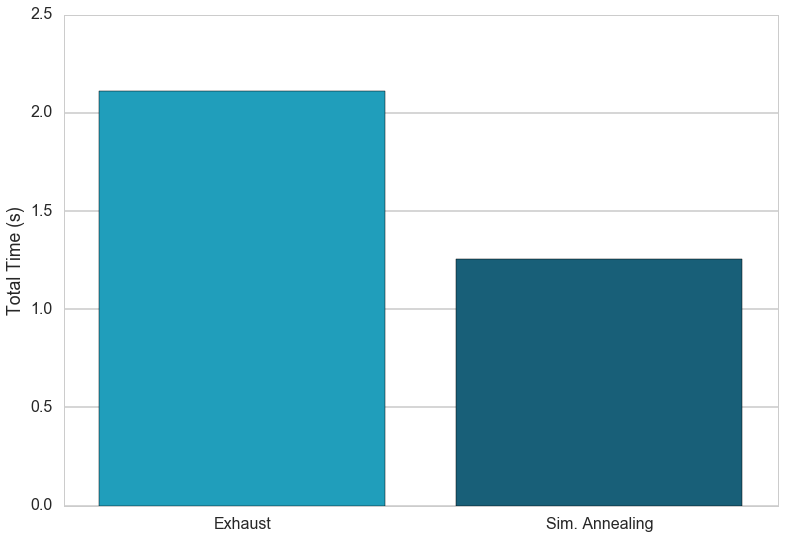

In [49]:
results = ((ExhaustiveSearch(smallTest), "Exhaust"), 
           (SimulatedAnnealing(smallTest), "Sim. Annealing"))
results = sorted(results, key=lambda x: x[0][2], reverse=True)
names = [x[1] for x in results]
times = [x[0][2] for x in results]
data = pd.DataFrame({'Algorithm' : names,
 'Calc Time' : times})
custom = ["#06AED5", "#086788", "#F0C808", "#FFF1D0", "#DD1C1A"] #set1 is also a good choice for color palette
sns.set_style(style="whitegrid")
sns.set_palette(custom)
sns.set_context("poster")
ax = sns.barplot(x="Algorithm", y="Calc Time",data=data, palette=sns.color_palette())
ax.set(xlabel='', ylabel='Total Time (s)')
plt.show()

From the graph, we can tell that simulated annealing performs fast than the exhaust, and we know from earlier too that it was providing a very accurate optimal solution. This is a very desirable combination. Now to prove a point of the calculation complexity of the simulated annealing algorithm, we can try out even larger sets of data! 

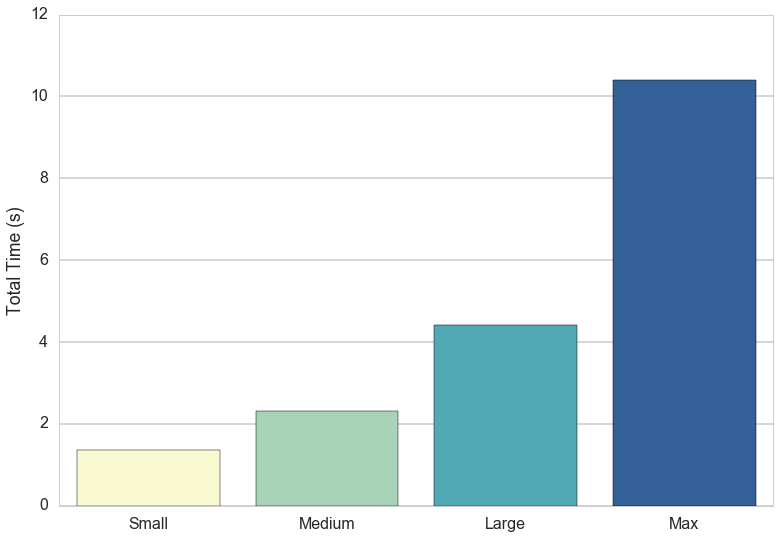

In [53]:
results = ((SimulatedAnnealing(smallTest), "Small"), 
          (SimulatedAnnealing(mediumTest), "Medium"),
          (SimulatedAnnealing(largeTest), "Large"),
          (SimulatedAnnealing(maxTest), "Max"))
results = sorted(results, key=lambda x: x[0][2], reverse=False)
names = [x[1] for x in results]
times = [x[0][2] for x in results]
data = pd.DataFrame({'Algorithm' : names,
 'Calc Time' : times})
custom = ["#FFFFCC", "#A1DAB4", "#41B6C4", "#225EA8"] #set1 is also a good choice for color palette
sns.set_style(style="whitegrid")
sns.set_palette(custom)
sns.set_context("poster")
ax = sns.barplot(x="Algorithm", y="Calc Time",data=data, palette=sns.color_palette())
ax.set(xlabel='', ylabel='Total Time (s)')
plt.show()

What is important about this graph, is that it show that as the size of the test set grows, the time is <i>not</i> growing exponentially with the number of cities. From the small test set (10 cities), to the max test set (97 cities), the time grows as a non-exponential function of number of cities. This means that even if we have a very larget test set, we could still expect the algorithm to perform in a reasonable amount of time. 

## Going Further

The Traveling Salesman Problem is so well researched that I could go on forever exploring and discussing the various algorithms and heuristics that can be used to solve and approximate the problem. However, given the flow of the problem, I would start by exploring a branch and bound algorithm. There are different ways to go about creating a branch and bound algorithm, but I found <a href="http://lcm.csa.iisc.ernet.in/dsa/node187.html">this place</a> to be a good start.  

The basic idea of a branch and bound algorithm is that you partition the solution space with different constraints by dictating which routes must or must not be taken. Then by setting lower bounds, and discounting nonsensical answers, you can significantly limit the number of potential solutions you have to consider, thus leading to a fair performing exact algorithm. 

From my own personal interest, I want to eventually explore <a href="https://en.wikipedia.org/wiki/Swarm_intelligence">swarm intelligence</a> algorithms. These are a class of nature-inspired algorithms that mimic the optimizing behavior of certain creatures like ants, bees, and bacteria, that by working together can approximate an optimal solution. That's for <i>Up Next</i>!



<b>Resources Used</b> 

On the applications of the TSP: 
http://cdn.intechopen.com/pdfs/12736/intech-traveling_salesman_problem_an_overview_of_applications_formulations_and_solution_approaches.pdf

Drilling circuit boards: 
http://link.springer.com/article/10.1007%2FBF01415960?LI=true


Routing school buses: 
http://pubsonline.informs.org/doi/abs/10.1287/mnsc.18.6.b279?journalCode=mnsc

The convergence of simulated annealing 
http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=295910